# 2ND TEAM  -  Project A : (Investment Comparison)

##### Team Members :
- Erfan Fahimnia  
- Hadi Behsaz  
- Ali Bazrkar

## Import Libraries

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preparation

In [2]:
# Define the tickers for each asset
tickers = {
    'Oil': 'CL=F',            # Crude Oil WTI
    'Gold': 'GC=F',           # Gold Futures
    'Dollar Index': 'DX-Y.NYB',  # US Dollar Index
    'Bitcoin': 'BTC-USD'      # Bitcoin USD
}

# Create an empty dictionary to store dataframes
dataframes = {}

# Set the start and end dates
start_date = '2015-01-01'
end_date = '2024-01-01'

# Download the data for each asset
for asset, ticker in tickers.items():
    data = yf.download(ticker, start=start_date, end=end_date)
    if 'Close' in data.columns:  # Ensure we have 'Close' data
        data['Asset'] = asset
        dataframes[asset] = data[['Close']].rename(columns={'Close': f'{asset} Price'})
    else:
        print(f"Warning: No 'Close' data for {asset} (Ticker: {ticker})")

# Merge the dataframes on Date, handle missing values if necessary
merged_data = pd.concat(dataframes.values(), axis=1, join='inner')

# Save the merged data to a CSV file
merged_data.to_csv('merged_asset_prices.csv')
# Read the CSV and parse dates
data = pd.read_csv("merged_asset_prices.csv", parse_dates=True, index_col=0)

# Calculate daily returns
returns = data.pct_change().dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


## Histogram Plot

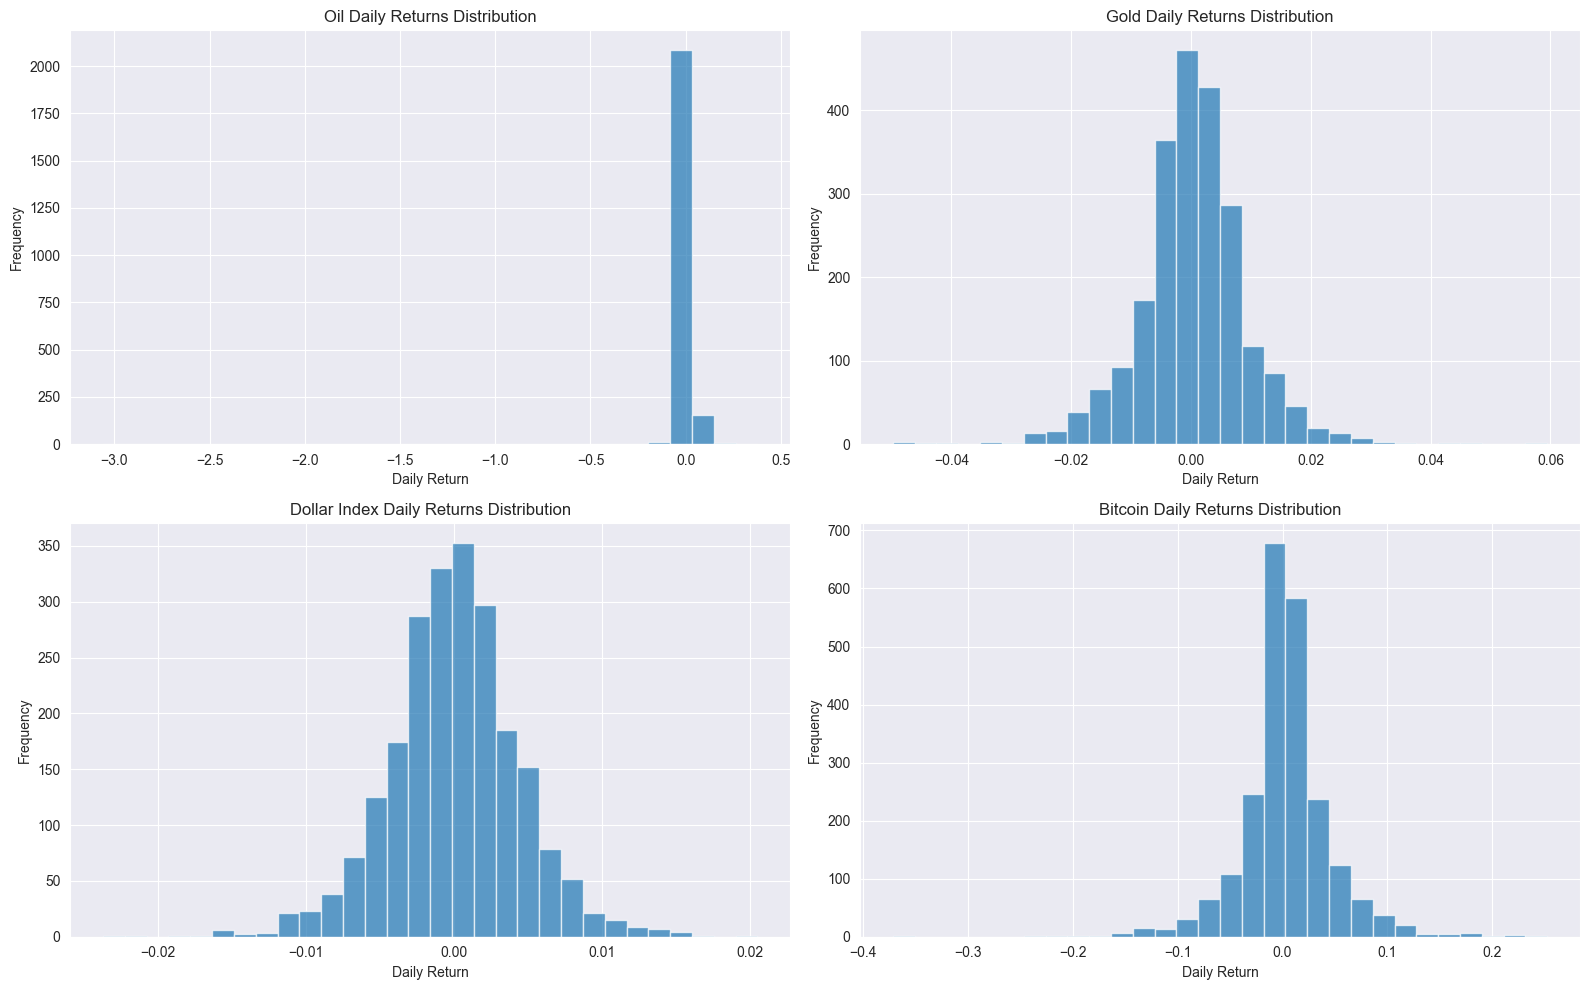

In [3]:
# Set the plot size for histograms
plt.figure(figsize=(16, 10))

# Create histograms for each asset's daily returns
for i, asset in enumerate(tickers.keys(), 1):
    plt.subplot(2, 2, i)
    plt.hist(returns[f'{asset} Price'], bins=30, alpha=0.7)
    plt.title(f'{asset} Daily Returns Distribution')
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Correlation

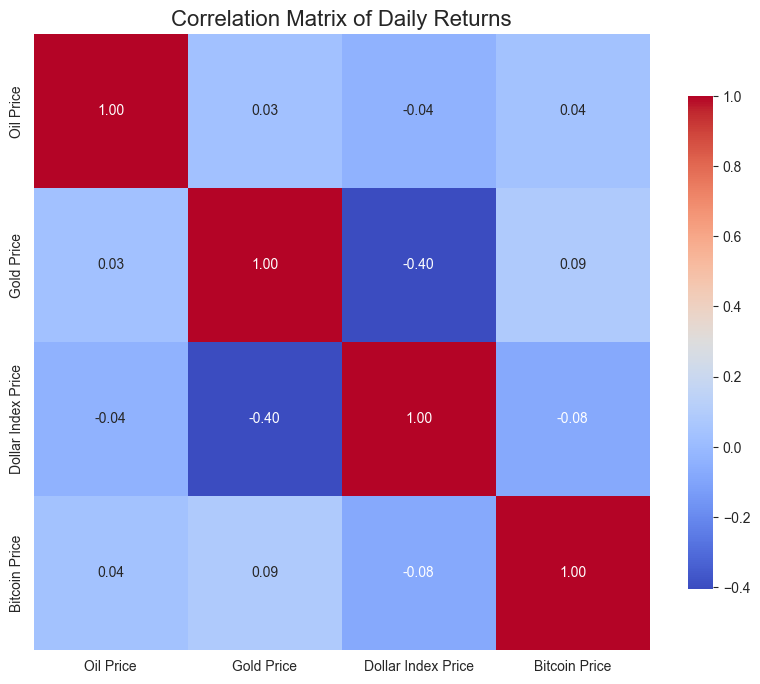

In [4]:
# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = returns.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Daily Returns', fontsize=16)
plt.show()

## Scatter Plot

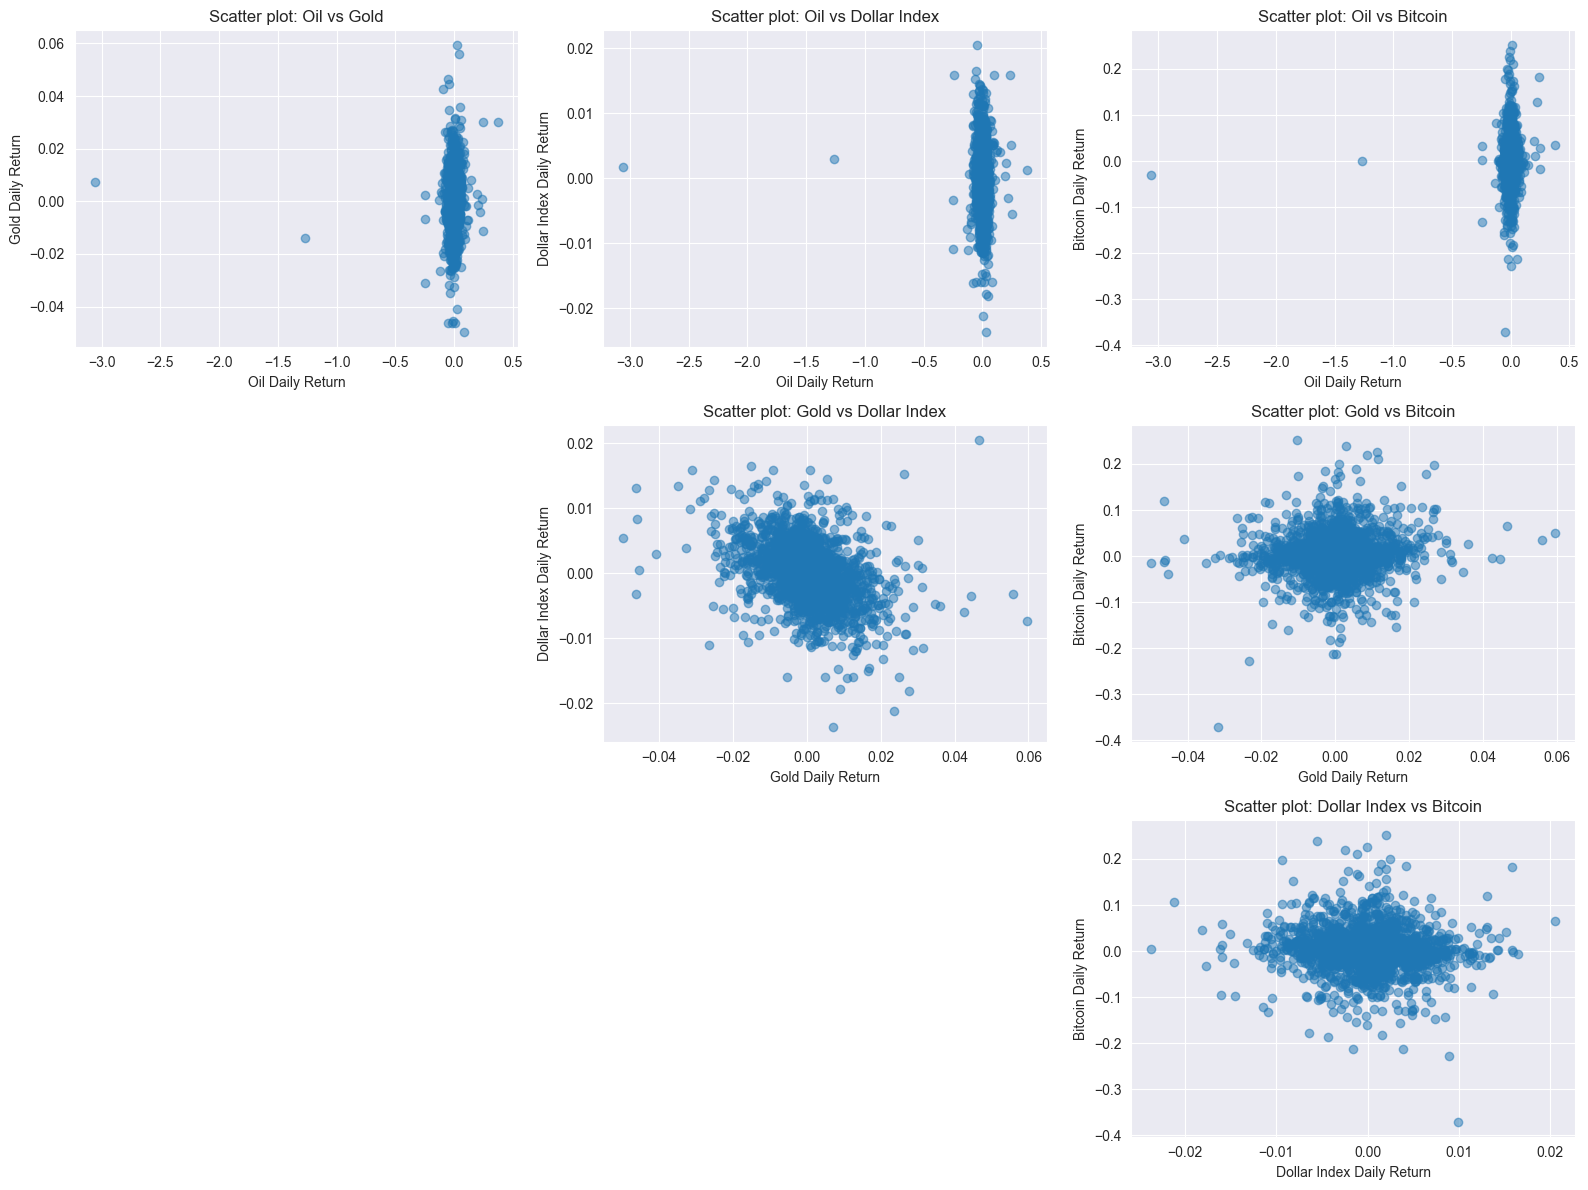

In [5]:
# Scatter plot pairs
plt.figure(figsize=(16, 12))
pairwise_assets = list(tickers.keys())
for i in range(len(pairwise_assets)):
    for j in range(i + 1, len(pairwise_assets)):
        plt.subplot(3, 3, i * (len(pairwise_assets)-1) + j)
        plt.scatter(returns[f'{pairwise_assets[i]} Price'], returns[f'{pairwise_assets[j]} Price'], alpha=0.5)
        plt.xlabel(f'{pairwise_assets[i]} Daily Return')
        plt.ylabel(f'{pairwise_assets[j]} Daily Return')
        plt.title(f'Scatter plot: {pairwise_assets[i]} vs {pairwise_assets[j]}')

plt.tight_layout()
plt.show()